In [1]:
# Imports
import sys
from pathlib import Path


In [2]:
# Find pyproject.toml in parent directories and add its directory to sys.path
path_curr = Path.cwd()
for parent in [path_curr] + list(path_curr.parents):
    pyproject_file = parent / "pyproject.toml"
    if pyproject_file.exists():
        sys.path.insert(0, str(parent))
        break

In [3]:
from src.camera.classes_camera import YOLOCameraManager
from src.servo.classes_servo import DualServoController

In [7]:
# initialize classes
dual_servo_controller = DualServoController()
yolo_camera_manager = YOLOCameraManager()

PCA9685 initialized successfully
PCA9685 initialized successfully
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


Camera __init__ sequence did not complete.
[0:37:36.933687236] [4371] ERROR Camera camera.cpp:702 Camera in Running state trying acquire() requiring state Available


Exception in thread Thread-4 (listen):
Traceback (most recent call last):
  File "/usr/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/usr/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maasyuki/Documents/2026/Projects/YOLO_on_Raspberry_Pi/.venv/lib/python3.13/site-packages/picamera2/picamera2.py", line 125, in listen
    callback()
    ~~~~~~~~^^
  File "/home/maasyuki/Documents/2026/Projects/YOLO_on_Raspberry_Pi/.venv/lib/python3.13/site-packages/picamera2/picamera2.py", line 142, in handle_request
    self.cameras[req.cookie]._requests += [CompletedRequest(req, self.cameras[req.cookie])]
                                           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maasyuki/Documents/2026/Projects/YOLO_on_Raspberry_Pi/.venv/lib/python3.13/site-packages/picamera2/request.py", line 100, in __init__
    s

RuntimeError: Camera __init__ sequence did not complete.

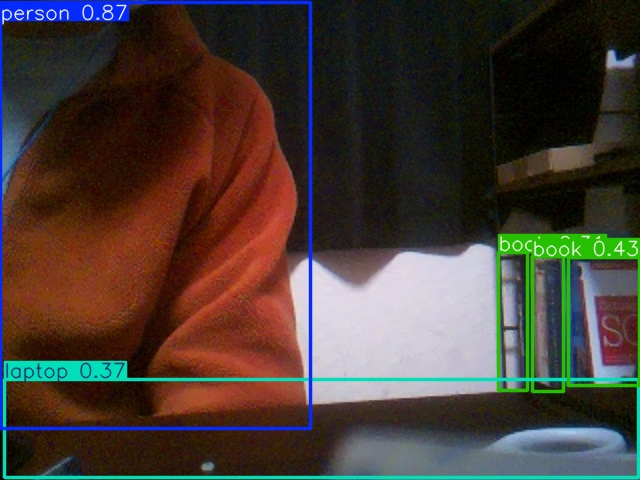

KeyboardInterrupt: 

In [5]:
yolo_camera_manager.display_annotated_video()

In [6]:
dual_servo_controller.move_by_angles(pan_angle=0, tilt_angle=-10)